# Burst Fitting example using BurstFit class

In [1]:
from burstfit.fit import BurstFit
from burstfit.data import BurstData
from burstfit.model import Model, SgramModel
from burstfit.utils.plotter import plot_me
from burstfit.utils.functions import pulse_fn_vec, sgram_fn_vec, gauss_norm, gauss_2d
from burstfit.utils.functions import gauss_dm, pulse_fn_vec_dm 
from burstfit.io import BurstIO
import logging
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
logging_format = "%(asctime)s - %(funcName)s -%(name)s - %(levelname)s - %(message)s"
logging.basicConfig(
    level=logging.INFO,
    format=logging_format,
)

In [3]:
#fil_file = '../tests/data/tcand_2_dm_565.30000_snr_11.92560.fil' # test data provided
#fil_file = '/data/dsa110/T1/corr02/2021_9_19_23_15_35/fil_210920aaai/210920aaai_98.fil' # our data (beam 98)
#fil_file = "/home/ubuntu/gechen/fake_data/test_1beams_10s.fil"
fil_file='/data/dsa110/T1/corr09/2021_10_8_0_29_27/fil_211009aacy/211009aacy_175.fil'
save_name = '211009aacy_175'

In [4]:
# fil_211009aacy 
bd = BurstData(
    fp=fil_file,
    dm=56.2,
    tcand=0.5, # pulse starting time in s.
    width=4, # width = 4 or 2^4 in time sample?  
    snr=27.0, 
    #kill_mask=np.array([False]),
    #min_samp=4./256-6
)

### check data 

In [5]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/home/ubuntu/proj/dsa110-shell/dsa110-T3/dsaT3/')
# import filplot_funcs as ff

sys.path.insert(1, '/home/ubuntu/gechen/software')
import filplot_funcs_gc as ff

/home/ubuntu/gechen/software/filplot_funcs_gc.py:20: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes
2021-12-02 22:44:43,080 - _logit -dsaStore - INFO - {"mjd": 59550.94772083776, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "dsaStore", "function": "_check_host", "level": "info", "time": "2021-12-02T22:44:43.080372Z", "msg": "TODO: implement"}
2021-12-02 22:44:43,082 - _logit -dsaStore - INFO - {"mjd": 59550.94772085575, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "dsaStore", "function": "_check_port", "level": "info", "time": "2021-12-02T22:44:43.081928Z", "msg": "TODO: implement"}
2021-12-02 22:44:43,084 - _logit -dsaStore - INFO - {"mjd": 59550.94772088028, "proj":

Secrets not found. Cannot use datacite API


2021-12-02 22:44:43,695 - _logit -dsaStore - INFO - {"mjd": 59550.94772795623, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "dsaStore", "function": "_check_host", "level": "info", "time": "2021-12-02T22:44:43.695403Z", "msg": "TODO: implement"}
2021-12-02 22:44:43,698 - _logit -dsaStore - INFO - {"mjd": 59550.94772798693, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "dsaStore", "function": "_check_port", "level": "info", "time": "2021-12-02T22:44:43.698061Z", "msg": "TODO: implement"}
2021-12-02 22:44:43,700 - _logit -dsaStore - INFO - {"mjd": 59550.94772801054, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "dsaStore", "function": "c-tor", "level": "info", "time": "2021-12-02T22:44:43.700098Z", "msg": "DsaStore created"}
2021-12-02 22:44:43,705 - _logit -Conf - INFO - {"mjd": 59550.947728060615, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "Conf", "function": "_che

In [6]:
nbin = 32
nfreq_plot = int(256/nbin)
print(nfreq_plot)

8


In [7]:
data, datadm, tsdm0, dms, datadm0 = ff.proc_cand_fil(fil_file, bd.dm, bd.width, nfreq_plot=nfreq_plot, ndm=32)

In [8]:
data_burst = data[:,int(0.45/bd.tsamp): int(0.55/bd.tsamp)]
print(nfreq_plot)

8


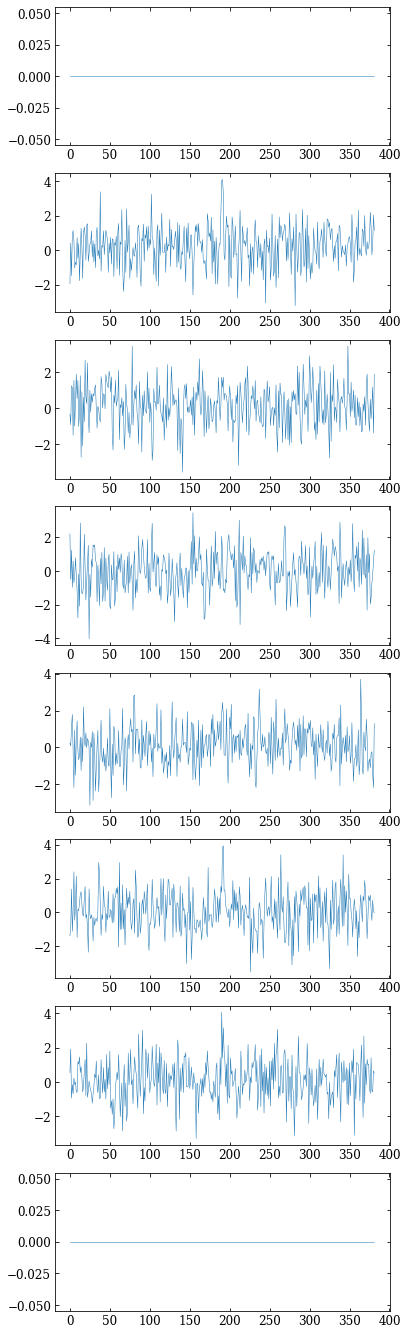

In [9]:
fig, ax = plt.subplots(nfreq_plot, 1, figsize=(6, 3*nfreq_plot))
for i in range(nfreq_plot):
    ax[i].plot(range(np.shape(data_burst)[1]), data_burst[i, :])

### check averaged lcv and spectrum 

(8, 15258)
15258.789062499998


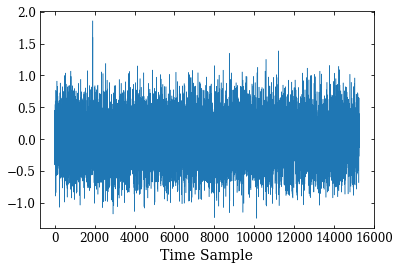

In [10]:
%matplotlib inline

plt.plot(range(len(data.mean(0))), data.mean(0))
plt.xlabel('Time Sample')

print(np.shape(data))
print(4./bd.tsamp) # /bd.width 4s per gulp, do not rebin by the pulse width 

Text(0.5, 0, 'Channels (binned)')

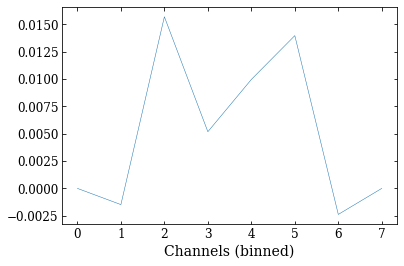

In [11]:
plt.plot(data.mean(1))
plt.xlabel('Channels (binned)')

## Fitting using BurstFit

In `BurstFit`, the fitting procedure for each component is as follows: 
1. Fit the profile using `curve_fit` and a profile model
2. Find the spectra using profile fit parameters
3. Fit the spectra using `curve_fit` and spectra model 
4. Use the profile and spectra fit parameters as initial guess and fit the 2D spectrogram using `curve_fit` and spectrogram model 

Therefore, `BurstFit` requires three functions: profile function, spectra function and spectrogram function. It is assumed that spectrogram function will use profile and spectra functions to make the spectrogram.   

Use the `Model` class to make profile and spectra models. You can optionally give names of the input parameters. These parameter names are used by `BurstFit` to automatically set relevant fitting bounds and priors.  

In [12]:
# For pulse, we will use a gaussian_dm convolved with an exponential model 
# S: Area of the pulse (fluence)
# mu: means of gaussians for each channel
# sigma: sigma of gaussian
# tau: scattering timescale for each channel
# t, S, delta_dm, t0, sigma, tau

pnames = ['S', 'delta_dm', 't0', 'sigma_t', 'tau']
pulseModel = Model(pulse_fn_vec_dm, param_names=pnames)

# For spectra, we will use a normalized gaussian model  
snames = ['mu_f', 'sigma_f']
spectraModel = Model(gauss_norm, param_names=snames)

Now we create a spectrogram model using `SgramModel` class, with the above two models and a spectrogram function (`sgram_fn_vec`)

### Select data near the burst time for fittings

In [13]:
sgram_mask = np.full(np.shape(data_burst), False)

In [14]:
sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn_vec, 
                        mask=sgram_mask, clip_fac=bd.clip_fac, other_param_names=["DM"])


Provide basic candidate information to `BurstFit`: sgram, model, DM, width, RFI mask, etc 

In [15]:
bf = BurstFit(
    sgram_model=sgramModel,
    sgram=data_burst, #bd.sgram not working 
    width=bd.width,
    dm=bd.dm,
    foff=bd.foff,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask= sgram_mask 
)

In [16]:
# Some setting up before we do the fitting 
bf.validate()
bf.precalc()

The fit results are saved as a dictionary of dictionaries. The keys of the dictionary are component numbers. For each component, the dictionary consists of keys: `popt` and `perr`, representing the fitted parameters and their 1-sigma errors. 

So, let's fit one component:

### Profile Fit

In [17]:
plot = True
profile_bounds=[]#((0, 0, 0, -np.inf),(np.inf, np.inf, np.inf, np.inf)) # did not work when only set up bounds but do not chop data 
bf.initial_profilefit(plot=plot, bounds=profile_bounds)

2021-12-02 22:45:05,684 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1


NameError: name 'nu_c' is not defined

### Spectra Fit

In [18]:
bf.make_spectra()

2021-12-02 23:17:53,164 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2021-12-02 23:17:53,165 - make_spectra -burstfit.fit - WARNING - mu not found in profile parameter names
2021-12-02 23:17:53,166 - make_spectra -burstfit.fit - WARNING - Making spectra using center bins. Could be inaccurate.


2021-12-02 23:17:54,204 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1
2021-12-02 23:17:54,244 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2021-12-02 23:17:54,246 - initial_spectrafit -burstfit.fit - INFO - mu_f: 3.9534418962121016 +- 1.6898880321513112
2021-12-02 23:17:54,247 - initial_spectrafit -burstfit.fit - INFO - sigma_f: 2.705706354168656 +- 1.3901920343772507


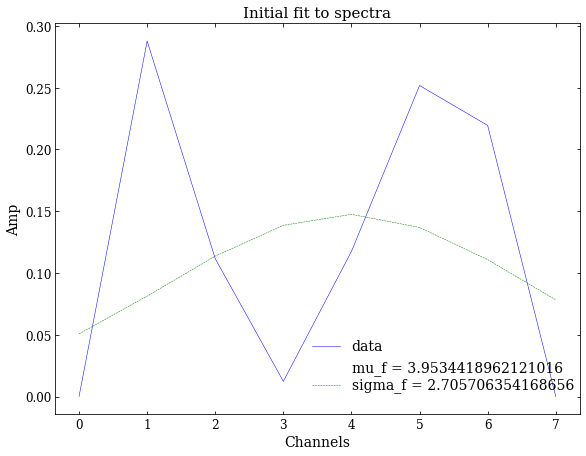

In [19]:
bf.initial_spectrafit(plot=plot)

Let's look at the profile and spectra fit parameters we just obtained 
(these were also printed in the logs above)

In [20]:
bf.profile_params

{}

In [21]:
bf.spectra_params

{1: {'popt': [3.9534418962121016, 2.705706354168656],
  'perr': array([1.68988803, 1.39019203])}}

Now the above parameters will be used as initial guess to do sgram fitting. 

### Spectrogram Fit

In [22]:
bf.sgram_fit(plot=plot)

2021-12-02 23:18:29,254 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1


KeyError: 1

We can see the reduced chi square value of our sgram_fit too

In [ ]:
bf.calc_redchisq()

The fit parameters can be accessed using bf.sgram_params. It shows only one component as we only did one component fitting.

In [ ]:
bf.sgram_params

## fitcycle()

All the above steps have also been wrapped with fitcycle() 

In [ ]:
bf.fitcycle(plot=True) #profile_bounds=[450, 550]

## fitall()

But `fitcycle()` only fits for one component. `BurstFit` can automatically fit for multiple components as well. For that we will use `fitall()`

Here it calls `fitcycle()` to fit for a component and then compares the ON-pulse residual with the OFF pulse regions (both left and right). If the distributions are similar then fitting is terminated. If the distributions aren't similar, then it tries to fit for another component. In the end, it will fit for all the components together. 

In [ ]:
bf.fitall(plot=True)

The logging above shows the results of the statistical tests performed to compare the ON pulse residual with OFF pulse regions. Both the Left and Right off pulse regions were found to be statistically similar to ON pulse residual, and therefore the fitting was terminated. 

Again, the parameters can be accessed using `sgram_params`. The final parameters are saved in "all" key. This is useful in case of multiple components. In that case, individual component number will show the fit results for inidividual component, while "all" will give the result of fitting all the components together. In this case, we just had one component, so `fit_all_components` wasn't used, and therefore key "1" and "all" have same parameters. 

In [ ]:
bf.sgram_params['all']

## Plotting Results 

We can also plot the model, sgram and residuals

In [ ]:
plot_me(bf.sgram)

In [ ]:
plot_me(bf.model)

In [ ]:
plot_me(bf.residual)

There are two ways of visualising plotting results using multi-panel plots. Using `plot_2d_fit` and `plot_fit_results`

In [ ]:
from burstfit.utils.plotter import plot_2d_fit, plot_fit_results

In [ ]:
plot_2d_fit(bf.sgram, bf.sgram_model.evaluate, bf.sgram_params['all'][1]['popt'], 
            bf.tsamp, show=True, save=False)

In [ ]:
plot_fit_results(bf.sgram, bf.sgram_model.evaluate, bf.sgram_params['all'][1]['popt'], 
                 bf.tsamp, bf.fch1, bf.foff, show=True, save=False)

Now, to save the fitting results we can use `BurstIO` class. See this notebook.  